# Penjelasan Kolom
1. Open:
* Harga saham pada saat pembukaan pasar pada hari perdagangan tertentu.
* Ini memberikan informasi tentang nilai saham sebelum perdagangan berlangsung.

2. High:
* Harga tertinggi yang dicapai oleh saham selama periode perdagangan (biasanya dalam satu hari).
* Ini menunjukkan potensi maksimum nilai saham selama waktu tertentu.

3. Low:
* Harga terendah yang dicapai oleh saham selama periode perdagangan.
* Memberikan wawasan tentang seberapa rendah harga saham dapat jatuh selama waktu tertentu.

3. Close:
* Harga saham pada akhir perdagangan pada hari tertentu.
* Ini adalah harga yang paling sering digunakan oleh trader dan analis untuk menganalisis performa saham.

4. Adj Close (Adjusted Close):
* Harga penutupan yang disesuaikan untuk dividen dan pemisahan saham (stock split).
* Ini memberikan gambaran yang lebih akurat tentang nilai saham dari waktu ke waktu, memperhitungkan peristiwa yang dapat memengaruhi harga saham.

5. Volume:
* Jumlah saham yang diperdagangkan selama periode perdagangan tertentu.
* Volume dapat memberikan informasi tentang likuiditas saham; volume tinggi biasanya menunjukkan minat yang kuat dari investor.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import xgboost as xgb
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
import mlflow
import mlflow.prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('fbprophet').disabled = True

In [2]:
df = pd.read_csv('data/raw/nvda stock prices data(2019-10-05 - 2024-10-05).csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-07,4.61450,4.7085,4.60575,4.60825,4.585943,480984000
1,2019-10-08,4.51600,4.5160,4.41250,4.43075,4.409302,444436000
2,2019-10-09,4.50800,4.5675,4.47900,4.51775,4.495882,292412000
3,2019-10-10,4.51550,4.6270,4.51025,4.57575,4.553602,309124000
4,2019-10-11,4.66025,4.7335,4.64125,4.64975,4.627243,446404000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df['date'] = pd.to_datetime(df['date'])

In [6]:
# fig = px.line(df, x = 'date', y = 'close', title = 'NVIDIA Stock Price (Closed)')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = df['date'],
    y = df['close'],
    mode = 'lines',
    name = 'Close Price'
))

fig.add_trace(go.Scatter(
    x = df['date'],
    y = df['adj_close'],
    mode = 'lines',
    name = 'Adj Close Price'
))

fig.update_layout(
    title = 'Close Price and Adj Close Price of NVIDIA Stock',
    xaxis_title = 'Date',
    yaxis_title = 'Price',
)
fig.show()

* Over the last five years, NVIDIA stock prices (Close and Adj Close) have shown a positive trend. After the COVID-19 pandemic (around 2022), the prices began to increase significantly.
* This comparison between Close and Adj Close indicates that there are no significant differences between the two prices, meaning it is acceptable to choose either the Close or Adj Close price.
* At a glance, this data exhibits a pattern (is non-stationary), but to confirm and reject this hypothesis, we will conduct the Augmented Dickey-Fuller Test, as referenced here: (https://www.statology.org/dickey-fuller-test-python/).
    * H0: The time series is non-stationary (has a pattern).
    * H1: The time series is stationary (has no pattern).
* If a p-value > 0.05: H0 fails ro be rejected
* If a p-value < 0.05: H0 rejected.

In [7]:
# Generate the ADF test and get p-value
p_value = adfuller(df['close'])[1]
if p_value > 0.05:
    print(f'p_value: {p_value}')
    print('H0 failes to be rejected. The time series is not stationary (has a trend or pattern)')
else:
    print(f'p_value: {p_value}')
    print('H0  rejected. The time series is stationary (has no pattern)')

p_value: 0.9975276111259581
H0 failes to be rejected. The time series is not stationary (has a trend or pattern)


* Augmented Dickey-Fuller (ADF) test show a result that the Close Price at this range time is non stationary
* This result also help us to use certain models that can handle non statsionary data

# Preprocessing

## Prepare Train and Test
* Since the values of the close and adj close columns do not differ significantly (there is almost no difference), I have decided to use the price close as the data for modeling. 
* In this case i will split the data into:
    * The first 4 years (2019 to 2023) data as train data
    * The last 2 years (2023 to 2025) data as test data


### Train Test Data for Prophet Model

In [8]:
df_final = df[['date','close']]
df_final.rename(columns = {'date':'ds', 'close':'y'},inplace = True)


df_train = df_final[df_final['ds'] <= '2024-03-31']
df_test = df_final[df_final['ds'] >= '2024-04-01']

In [14]:
df_train.to_csv('data/processed/train.csv', index = False)
df_test.to_csv('data/processed/test.csv', index = False)

Text(0, 0.5, 'Closed Price')

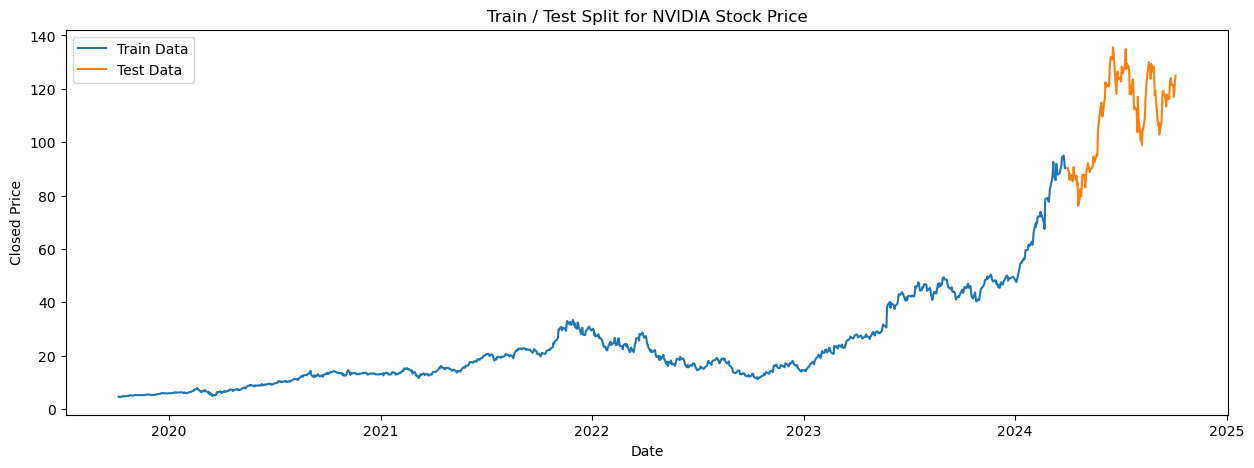

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df_train['ds'],df_train['y'], label = "Train Data")
plt.plot(df_test['ds'],df_test['y'], label = "Test Data")
plt.legend()
plt.title('Train / Test Split for NVIDIA Stock Price')
plt.xlabel('Date')
plt.ylabel('Closed Price')



In [ ]:
#Check is there any trade in holidays date
us_calendar = USFederalHolidayCalendar()
if df_train['ds'].dt.weekday.isin(us_calendar.holidays()).sum() == 0:
    print('US Market are Closed in Holidays Date')
else:
    print('US Market are Open in Holidays')

US Market are Closed in Holidays Date


* The code above ensures that our dataframe does not contain stock price data on holiday dates.
* To ensure that our Prophet model is accurate and better reflects real-world conditions, we must define our future dataframe so that it only contains business days, based on the US Federal Calendar, which we will define below

In [ ]:
last_date = df_train['ds'].max() #Get laast date of train data as a starting point
def next_business_day(date): #This function will return business days only based on US Federal Calendar
    next_day = date + pd.Timedelta(days = 1)
    while next_day.weekday() >= 5 or next_day in us_calendar.holidays():
        next_day += pd.Timedelta(days = 1)
    return next_day

future_dates = [] #List that will stored all future dates
current_date = next_business_day(last_date)
while len(future_dates) < len(df_test):
    if current_date.weekday() < 5 and current_date not in us_calendar.holidays():
        future_dates.append(current_date)
    current_date = next_business_day(current_date)

future = pd.DataFrame({'ds':future_dates}) #Convert list into pandas dataframe with 'ds' as a column


### Train Test Data for other Machine Learning Models

# Modeling

## Facebook Prophet (Base)

In [ ]:
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(df_train)
forecast = prophet_model.predict(future)
df_predicted = forecast[['ds', 'yhat']].rename(columns = {'ds':'ds', 'yhat':'y_pred_prophet'})

12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:03 - cmdstanpy - INFO - Chain [1] done processing


### Test to Predicted Data Visualization with Metrics Evaluation

Mean Squared Error (MSE) Score: 224.85


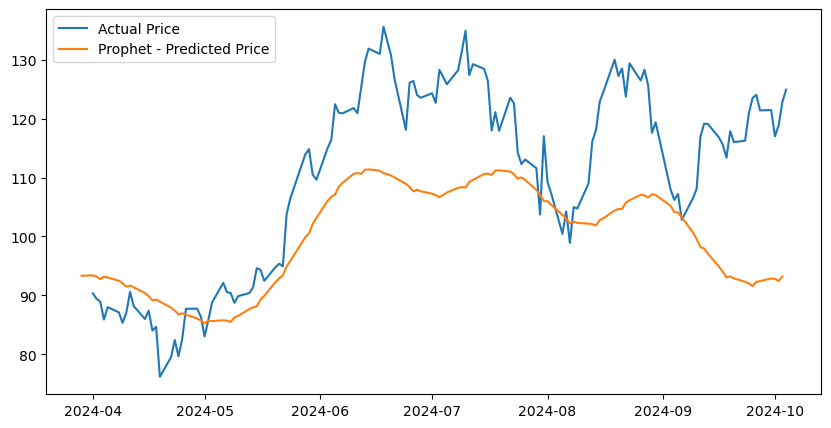

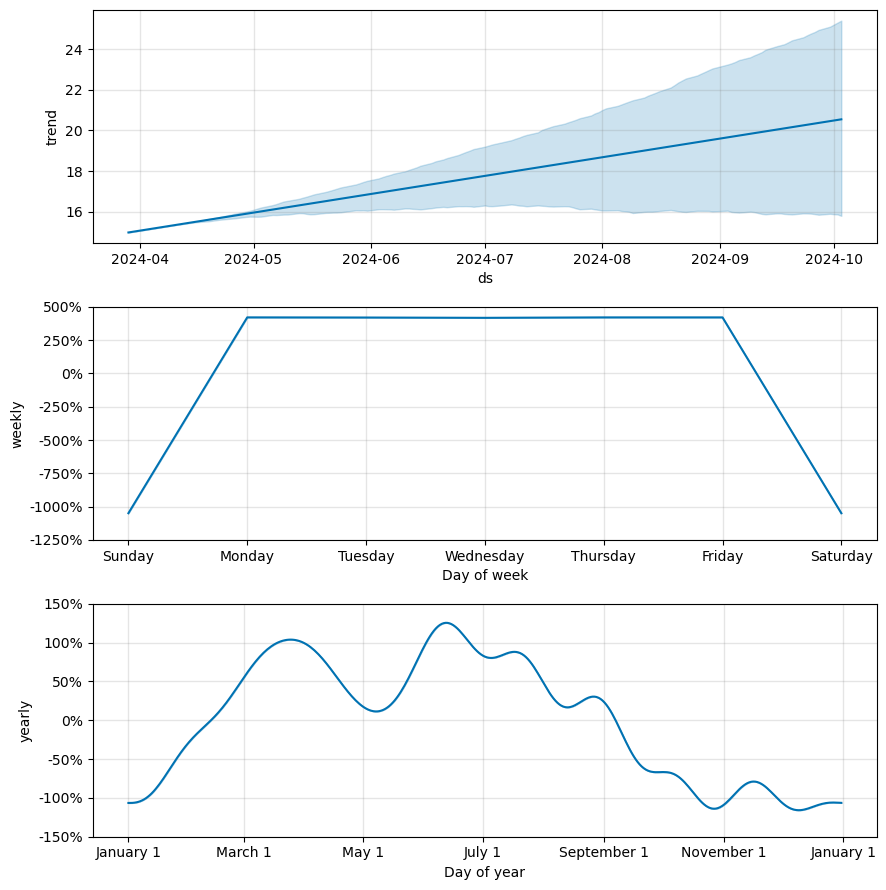

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.figure(figsize=(15,5))
ax.plot(df_test['ds'], df_test['y'], label = 'Actual Price ')
ax.plot(df_predicted['ds'], df_predicted['y_pred_prophet'], label = 'Prophet - Predicted Price')
ax.legend()
prophet_model.plot_components(forecast)


# plt.plot(df_test['ds'], df_test['y_pred_sarimax'], label = 'SARIMAX - Predicted Price')
# plt.plot(forecast_opt['ds'], forecast_opt['yhat'], label = 'Price Predicted Data - Optimal')



mse = mean_squared_error(df_test['y'], forecast['yhat'])
# mse_opt = mean_squared_error(df_test['y'], forecast_opt['yhat'])
print(f'Mean Squared Error (MSE) Score: {mse:.2f}')
# print(f'Mean Squared Error (MSE) Score Optimized: {mse_opt:.2f}')

In [ ]:
best_mse_score = 0
# for seasonality_mode in ['additive', 'multiplicative']:
    # for holidays_prior_scale in [0.01, 0.1, 1.0, 10.0]:
for changepoint_prior_scale in [0.001, 0.01, 0.1, 0.5]:
    for seasonality_prior_scale in [0.01, 0.1, 1.0, 10.0]:
        prophet_model_opt = Prophet(
            # seasonality_mode=seasonality_mode,
            # holidays_prior_scale=holidays_prior_scale,
            seasonality_mode='multiplicative',
            changepoint_prior_scale = changepoint_prior_scale, 
            seasonality_prior_scale = seasonality_prior_scale)
        prophet_model_opt.fit(df_train)
        df_cv_opt = cross_validation(prophet_model_opt, horizon='192 days', parallel='processes')
        df_p = performance_metrics(df_cv_opt)
        mse_score = np.mean(df_p['mse'])
        if mse_score > best_mse_score:
            best_mse_score = mse_score
            best_param = {
                'seasonality_mode': 'multiplicative',
                # 'holidays_prior_scale': holidays_prior_scale,
                'changepoint_prior_scale': changepoint_prior_scale, 
                'seasonality_prior_scale': seasonality_prior_scale}

        
print(f'Best Mean Squared Error (MSE) Score: {best_mse_score:.2f}')
print(f'Best Parameter: {best_param}')

12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:07 - cmdstanpy - INFO - Chain [1] done processing
12:40:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:40:07 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing
12:40:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:40:18 - cmdstanpy - INFO - Chain [1] start processing
12:40:20 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - INFO - Chain [1] start processing
12:40:28 - cmdstanpy - INFO - Chain [1] done processing
12:40:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Mean Squared Error (MSE) Score: 255.72
Best Parameter: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


Train under 2023, test over 2024:
* Best Mean Squared Error (MSE) Score: 360.52
* Best Parameter: {'seasonality_mode': 'multiplicative', 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}

Train under 2024-03 test over 2024-04:
* Best Mean Squared Error (MSE) Score: 255.72
* Best Parameter: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}

In [ ]:
prophet_model_opt = Prophet(**best_param) #Gunakan ** untuk unpack dictionary
prophet_model_opt.fit(df_train)
forecast_opt = prophet_model_opt.predict(future)
df_predicted_opt = forecast_opt[['ds', 'yhat']].rename(columns = {'ds':'ds', 'yhat':'y_pred_prophet'})

12:43:09 - cmdstanpy - INFO - Chain [1] start processing
12:43:10 - cmdstanpy - INFO - Chain [1] done processing


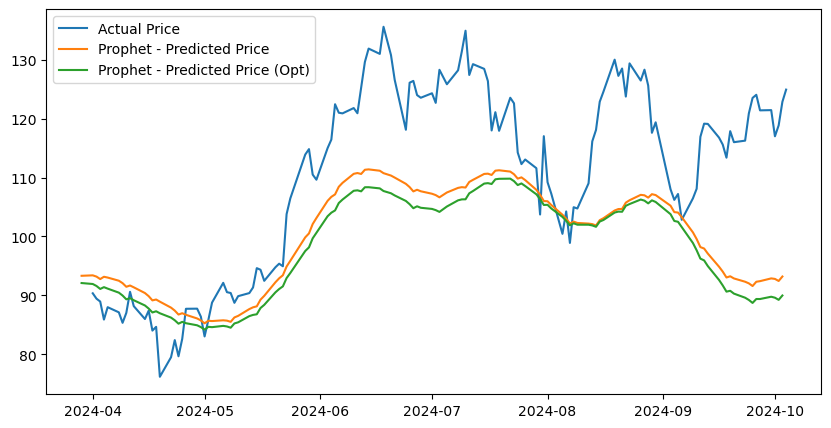

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.figure(figsize=(15,5))
ax.plot(df_test['ds'], df_test['y'], label = 'Actual Price ')
ax.plot(df_predicted['ds'], df_predicted['y_pred_prophet'], label = 'Prophet - Predicted Price')
ax.plot(df_predicted_opt['ds'], df_predicted_opt['y_pred_prophet'], label = 'Prophet - Predicted Price (Opt)')
ax.legend()
fig.show()

In [ ]:
df_predicted_opt

,ds,y_pred_prophet
0,2024-03-29,92.103021
1,2024-04-01,91.940932
2,2024-04-02,91.604681
3,2024-04-03,91.101234
4,2024-04-04,91.407197
...,...,...
126,2024-09-27,89.391906
127,2024-09-30,89.779466
128,2024-10-01,89.616624
129,2024-10-02,89.251190


In [ ]:
mse_opt = mean_squared_error(df_test['y'], df_predicted_opt['y_pred_prophet'])
mse

271.8886382751031